# Data cleaning, merging and Geopandas choropleth creation

## 1. Importing relevant libraries

In [1]:
import geopandas as gpd 
import geoplot as gplt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors

## 2. Functions for Data Cleaning and Merging



##### The first function takes in a CSV of hosptial resources for a specific state. This CSV was downloaded from:
<a> https://healthdata.gov/Hospital/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/anag-cw7u/about_data <a> 
##### The data set was filtered by state on the website and exported as a CSV with state specific information. The data was filtered for entries only from January 2021. The 'total_beds_7_day_sum' column (total number of staffed beds at a specific hosptial) and 'inpatient_beds_used_covid_7_day_sum' column (number of inpatient beds used by COVID patients) were used to calculate the percentage of beds used per hospital. The data was then grouped by counties and returned the mean percentage of beds used per country. 

##### The second function takes in a CSV of weekly cases and deaths for a specific state. This CSV was downloaded from:
<a>https://data.cdc.gov/dataset/Weekly-United-States-COVID-19-Cases-and-Deaths-by-/yviw-z6j5<a>
##### The data set was filtered by state on the webiste and exported as a CSV with state specific information. The data was filtered for entries only from January 2021. The 'new_deaths' column was used to find the total number of new deaths per county in the specific state. 

The third function merges the two dataframes returned from the previous functions based on county (fips_code).

In [2]:
def beds_used(csv):
    hdf = pd.read_csv(csv) #load the csv
    hdf['collection_week'] = pd.to_datetime(hdf['collection_week']) # convert the collection week column to datetime format
    hdf['year'] = hdf['collection_week'].dt.year # create a separate column for the year
    hdf['month'] = hdf['collection_week'].dt.month # create a separate column for the month
    hdr= hdf[(hdf['year']==2021) & (hdf['month']== 1) & (hdf['inpatient_beds_used_covid_7_day_sum'] >1)] # filter for January 2021 and filter out the negative values in the beds used colulmn
    sdf= hdr[['hospital_name','year','month','fips_code','total_beds_7_day_sum','inpatient_beds_used_covid_7_day_sum']].copy().dropna() # select the columns interested in
    sdf["Percent_used"] = ((sdf['inpatient_beds_used_covid_7_day_sum'] / sdf['total_beds_7_day_sum']) * 100).astype(int) # calcualte the percentage of beds used
    averages = sdf.groupby('fips_code')['Percent_used'].mean().to_frame() # create a new dataframe with the average percentage beds used per county
    return averages

def new_deaths (csv):
    cases = pd.read_csv(csv) # lodad the csv
    cases['date'] = pd.to_datetime(cases['date']) # convert the date column to datetime format
    cases['year'] = cases['date'].dt.year # create a separate column for the year
    cases['month'] = cases['date'].dt.month # create a separate column for the month
    fdr= cases[(cases['year']==2021) & (cases['month']== 1)] # filter for January 2021
    newdeaths = fdr.groupby('fips_code')['New deaths'].sum().to_frame() # create a new datadrame with the total number of new deaths per county
    return newdeaths

def merged (csv_death, csv_hospital):
    merged_df = new_deaths(csv_death).join(beds_used(csv_hospital)).fillna(0) #merge the two new data frames together on fips_code
    return merged_df 



## 2. Running the functions on the Michigan data

In [3]:
merged_df = merged('downloads/Cases.csv','downloads/michigan.csv')
merged_df

,New deaths,Percent_used
fips_code,,
26000,18,0.000000
26001,9,0.000000
26003,1,7.250000
26005,34,8.000000
26007,18,4.400000
...,...,...
26157,37,5.714286
26159,14,10.857143
26161,31,5.833333


## 3. Loading the data geospatial data

In [4]:
# Load the json file with county coordinates
g = gpd.read_file('https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/US-counties.geojson')

g

,id,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry
0,01001,0500000US01001,01,001,Autauga,County,594.436,"POLYGON ((-86.49677 32.34444, -86.71790 32.402..."
1,01009,0500000US01009,01,009,Blount,County,644.776,"POLYGON ((-86.57780 33.76532, -86.75914 33.840..."
2,01017,0500000US01017,01,017,Chambers,County,596.531,"POLYGON ((-85.18413 32.87053, -85.12342 32.772..."
3,01021,0500000US01021,01,021,Chilton,County,692.854,"POLYGON ((-86.51734 33.02057, -86.51596 32.929..."
4,01033,0500000US01033,01,033,Colbert,County,592.619,"POLYGON ((-88.13999 34.58170, -88.13925 34.587..."
...,...,...,...,...,...,...,...,...
3216,51001,0500000US51001,51,001,Accomack,County,449.496,"MULTIPOLYGON (((-75.24227 38.02721, -75.29687 ..."
3217,51021,0500000US51021,51,021,Bland,County,357.725,"POLYGON ((-81.22510 37.23487, -81.20477 37.243..."
3218,51027,0500000US51027,51,027,Buchanan,County,502.763,"POLYGON ((-81.96830 37.53780, -81.92787 37.512..."
3219,51037,0500000US51037,51,037,Charlotte,County,475.271,"POLYGON ((-78.44332 37.07940, -78.49303 36.891..."


## 4. Merging geospatial data with COVID data

In [5]:
msdf = g.loc[g['STATE'] == '26'].copy() # filter geospatial data for Michigan
msdf['id'] = pd.to_numeric(msdf['id']) # change datatype of id column for merging 
map_merged = msdf.set_index('id').join(merged_df) # merging geospatial Michigan data with COVID Michigan data
map_merged 


,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry,New deaths,Percent_used
id,,,,,,,,,
26009,0500000US26009,26,009,Antrim,County,475.703,"POLYGON ((-85.33284 44.81237, -85.44225 44.859...",8,0.00
26015,0500000US26015,26,015,Barry,County,553.092,"POLYGON ((-85.07425 42.77078, -85.07161 42.421...",6,5.25
26023,0500000US26023,26,023,Branch,County,506.369,"POLYGON ((-85.25985 42.07185, -84.82649 42.072...",12,5.60
26035,0500000US26035,26,035,Clare,County,564.315,"POLYGON ((-84.60810 44.16048, -84.60800 44.158...",27,6.20
26037,0500000US26037,26,037,Clinton,County,566.408,"POLYGON ((-84.36780 43.11794, -84.36571 42.955...",22,3.00
...,...,...,...,...,...,...,...,...,...
26151,0500000US26151,26,151,Sanilac,County,962.566,"POLYGON ((-82.99626 43.15410, -83.00043 43.284...",15,4.25
26153,0500000US26153,26,153,Schoolcraft,County,1171.358,"POLYGON ((-85.86540 45.96826, -85.88244 45.968...",1,0.00
26053,0500000US26053,26,053,Gogebic,County,1101.849,"POLYGON ((-88.99089 46.09733, -89.05875 46.124...",5,2.20


## 5. Create a choropleth map of the percentage of beds used in January 2021 in Michigan

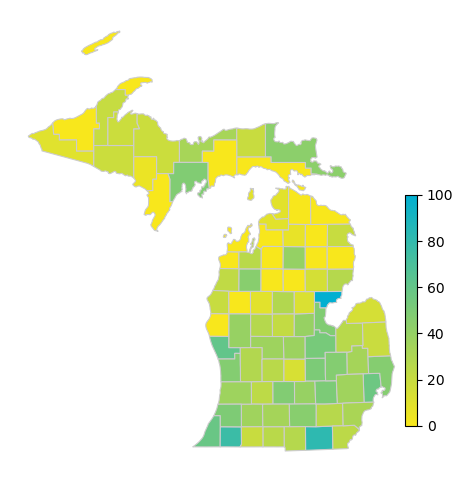

In [6]:
variable = 'Percent_used' # set a variable that will call whatever column we want to visualise on the map
vmin, vmax = 0, 100 # set the range for the choropleth
fig, ax = plt.subplots(1, figsize=(10, 6)) # create figure and axes for Matplotlib
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['#f8e71c','#01afd1']) # set colors for map
map_merged.plot(column=variable, cmap=cmap, linewidth=0.8, ax=ax, edgecolor='0.8') # plot the data on the map
ax.axis('off')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax)) # add the colorbar to the map
sm.set_array([])
cax=ax.inset_axes([0.98, 0.1, 0.03, 0.5])
cbar = fig.colorbar(sm,cax)

## 6. Create a choropleth map of new COVID cases in Michigan

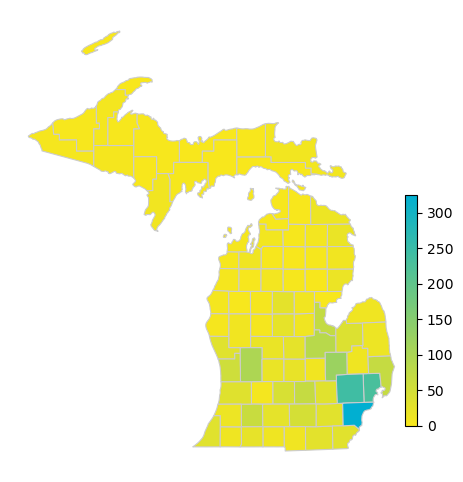

In [7]:
variable = 'New deaths' # set a variable that will call whatever column we want to visualise on the map
vmin, vmax = map_merged['New deaths'].min() , map_merged['New deaths'].max()# set the range for the choropleth
fig, ax = plt.subplots(1, figsize=(10, 6))# create figure and axes for Matplotlib
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['#f8e71c','#01afd1']) #select colors for map
map_merged.plot(column=variable, cmap=cmap, linewidth=0.8, ax=ax, edgecolor='0.8') # plot the data on the map
ax.axis('off')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax) # create colorbor for the map
sm.set_array([])
cax=ax.inset_axes([0.98, 0.1, 0.03, 0.5])
cbar = fig.colorbar(sm,cax)